# Pairs Trading for Fun and Profit

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys

if sys.path[-1] != '../':
    sys.path.append('../')

from analysis.plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('./data/prices_Mar_2022.csv', parse_dates=[0], index_col=[0])
data.ffill(inplace=True)
data.isna().sum().sum()
price = data.copy()

In [3]:
start = '2022-03-07'
end = '2022-03-18'
trading_start = '2022-03-21'
trading_end = '2022-03-25'

formation_price = price.loc[start:end]
trading_price = price.loc[end:trading_end]
formation_price.shape

(3910, 493)

# 1. Pair Selection
Pairs Trading is one of the most valuable market-neutral strategies used by hedge funds. It is particularly interesting because it overcomes the arduous process of valuing securities by focusing on relative pricing. By buying a relatively undervalued security and selling a relatively overvalued one, a profit can be made upon the pair’s price convergence. However, with the growing availability of data, it became increasingly harder to find rewarding pairs. In this work, we address two problems: (i) how to find profitable pairs while constraining the search space and (ii) how to avoid long decline periods due to prolonged divergent pairs. To manage these difficulties, the application of machine learning and promising statistical techniques are investigated in detail. We propose the integration of an Unsupervised Learning algorithm, OPTICS, to handle problem (i). 

In [4]:
from pairs.selection import PairSelection

## 1.1 Clustering

To decide which algorithm is more appropriate, some problem-specific requisites are first defined:
- No need to specify the number of clusters in advance.
- No need to group all securities.
- Strict assignment that accounts for outliers.
- No assumptions regarding the clusters’ shape.
  
By making the number of clusters data-driven, we introduce as little bias as possible. Furthermore, outliers should not be incorporated in the clusters, and therefore grouping all assets should not be enforced. In addition, the assignment should be strict, otherwise the number of possible pair combinations increases, which is conflicting with the initial goal. Finally, due to the nonexistence of prior information that indicates the clusters should be regularly shaped, the selected algorithm should not assume this.
   
#### DBSCAN  
Taking into consideration the previously described requirements, a density-based clustering algorithm seems an appropriate choice. It forms clusters with arbitrary shapes, and thus no gaussianity assumptions need to be adopted. It is naturally robust to outliers as it does not group every point in the data set. Furthermore, it requires no specification of the number of clusters.
  
The DBSCAN algorithm is the most influential in this category. Briefly, DBSCAN detects clusters of points based on their density. To accomplish that, two parameters need to be defined: $\epsilon$, which specifies how close points should be to each other to be considered “neighbours”, and minPts, the minimum number of points to form a cluster. From these two parameters, in conjugation with some concepts that we omit here, clusters of neighbouring points are formed. Points falling in regions with less than minPts within a circle of radius $\epsilon$ are classified as outliers, hence not affecting the results. Nevertheless, DBSCAN still carries one drawback. The algorithm is appropriate under the assumption that clusters are evenly dense. However, if regions in space have different densities, a fixed $\epsilon$ may be well adapted to one given cluster density, but it might be unrealistic for another.
  
#### OPTICS 
The OPTICS algorithm addresses this problem. OPTICS is based on DBSCAN, with the introduction of some notions that accomplish a varying $\epsilon$ implementation. In this enhanced setting, the investor is only required to specify the parameter minPts, as the algorithm is capable of detecting the most appropriate $\epsilon$ for each cluster. Therefore, we propose using OPTICS not just to account for varying cluster densities but also to facilitate the investor’s task.

In [8]:
ps = PairSelection(formation_price)
ps.create_clusters()

- The graphs below show that the groups created by OPTICS indeed have a lot of similarity in their movements.

sym_root                             
            count                         join
Clusters                                      
0               4           A, GOOG, ROST, WAT
1               4            DTE, ED, LNT, WEC
2               6  DOV, FIS, GPN, IP, NWS, WTW
3               5      ADP, EVRG, MRK, SO, SRE
4               5   AJG, KEYS, MMC, NDAQ, POOL
5               5     IRM, KMI, TSN, WMB, XRAY

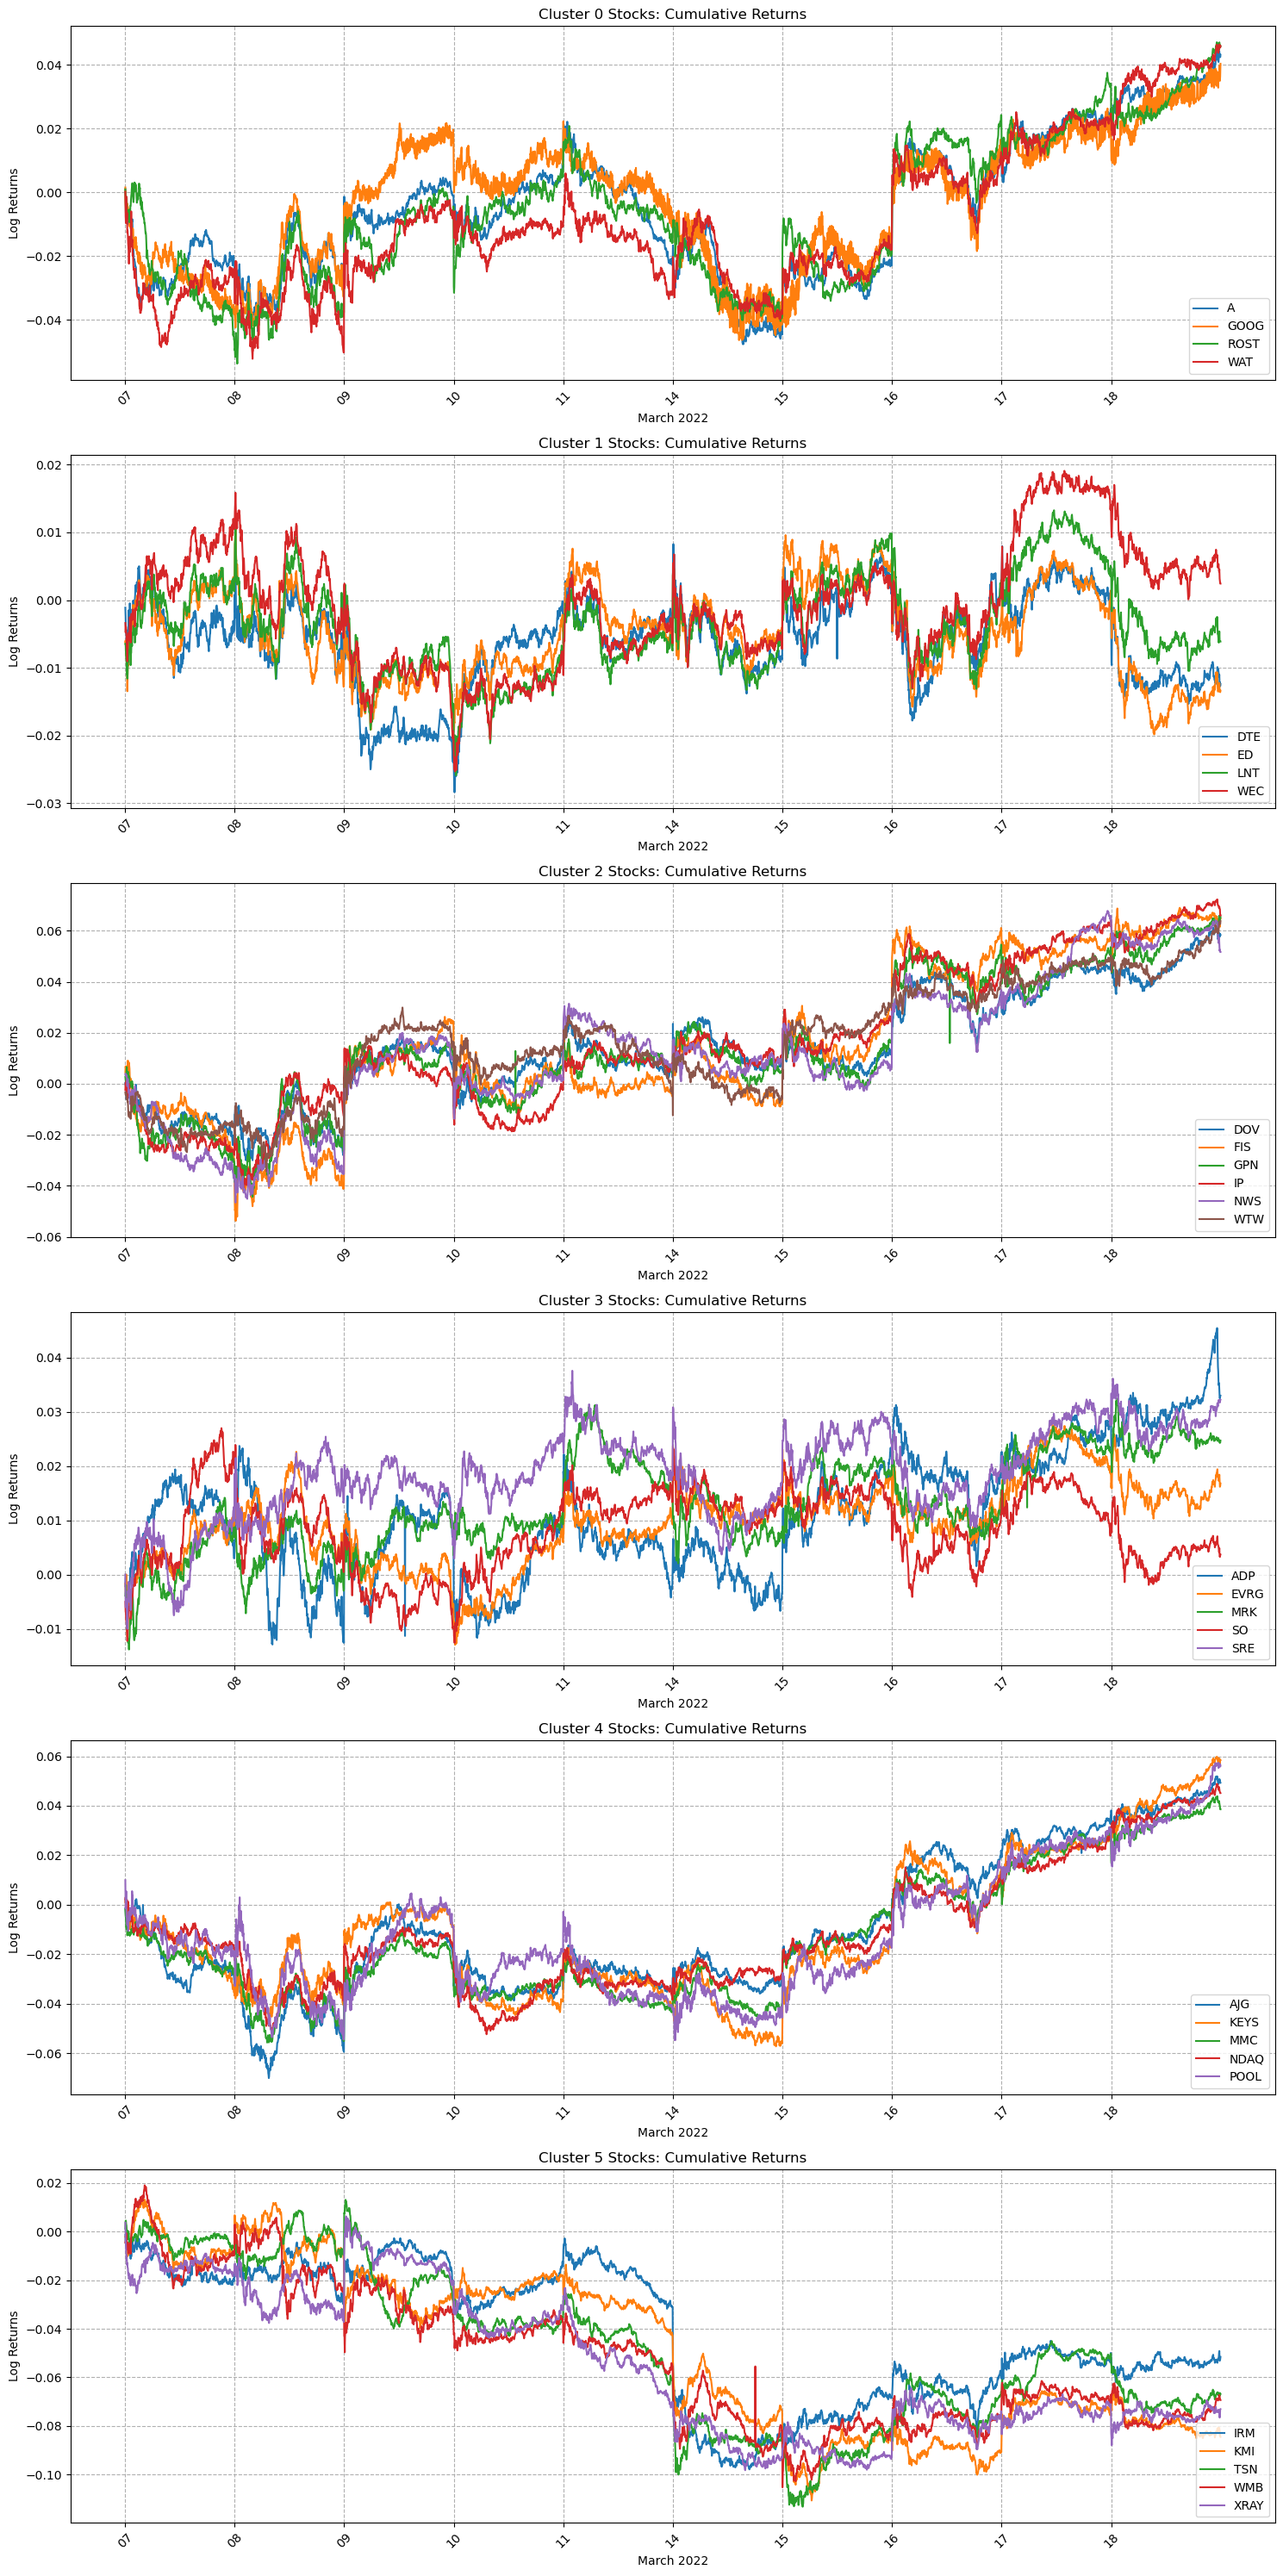

In [9]:
display(ps.groups)
get_group = lambda x: ps.groups.loc[x, ('sym_root', 'join')].split(', ')
number_of_groups = len(ps.groups)

fig, ax = plt.subplots(number_of_groups, 1, figsize=(15,5*number_of_groups))

x_minutes = ps.log_returns.index
x_plot = range(0, len(x_minutes))
x_labels = x_minutes[~x_minutes.strftime("%d").duplicated()]
x_ticks = np.where(np.in1d(x_minutes, x_labels))[0]

for i in ps.groups.index:
    syms_in_group = get_group(i)
    for s in syms_in_group:
        y = ps.log_returns[s]
        ax[i].plot(x_plot, y, label=s)

    ax[i].set_xticks(x_ticks, x_labels.strftime("%d"), rotation=45)

    ax[i].legend(loc=4)
    ax[i].grid(linestyle='--')
    ax[i].set_title(f'Cluster {i} Stocks: Cumulative Returns')
    ax[i].set_ylabel('Log Returns')
    ax[i].set_xlabel('March 2022')

plt.tight_layout()
plt.show()

## 1.2 Top pairs by co-integration
The Engle-Granger test for cointegration is a statistical method used to determine whether two time series are cointegrated, meaning that they share a common long-term trend despite short-term fluctuations.  
  
In pairs trading, the Engle-Granger test can be used to identify pairs of stocks that are likely to move together over time. To apply the test, one first selects a set of potential pairs based on some relevant criteria (such as belonging to the same industry or having similar market capitalizations), here, we use clustering technique OPTICS.
  
Next, the historical price data for each stock in the pair is analyzed to determine whether they are cointegrated using the Engle-Granger test. If they are found to be cointegrated, this suggests that there is a long-term relationship between the two stocks that can be exploited for pairs trading.

We rank the pairs using the p-value.

In [8]:
ps.test_coint()
ps.coint_result.head(30)

,sym1,sym2,cluster,p,t,1%,5%,10%
0,DOV,GPN,2,0.000033,-5.369208,-3.899244,-3.337694,-3.045535
1,MRK,SRE,3,0.000447,-4.758386,-3.899244,-3.337694,-3.045535
2,GPN,IP,2,0.000885,-4.584838,-3.899244,-3.337694,-3.045535
3,A,ROST,0,0.001346,-4.474912,-3.899244,-3.337694,-3.045535
4,WMB,XRAY,5,0.003098,-4.246549,-3.899244,-3.337694,-3.045535
5,TSN,WMB,5,0.007187,-3.99974,-3.899244,-3.337694,-3.045535
6,ROST,WAT,0,0.007726,-3.977653,-3.899244,-3.337694,-3.045535
7,GPN,WTW,2,0.010375,-3.885845,-3.899244,-3.337694,-3.045535
8,DOV,NWS,2,0.011094,-3.864576,-3.899244,-3.337694,-3.045535
9,DOV,FIS,2,0.017086,-3.723564,-3.899244,-3.337694,-3.045535


## 1.3 Top pair selection
The top pair selection is done by making sure that the symbol in any already selected pair is not repeated so that we do not end up repeating exposure in certain stocks.  

Secondly, we also limit ourselves to pairs that have a p-value <= 0.05. This ensures that we are trading pairs which we are confident about being cointegrated.

This does result in weeks where we may end up with less than desired or no pairs to trade.  
  
Here, you can see the pairs we end up selecting are not in fact the top 'n' pairs of the above result.

In [4]:
# pairs_selected = ps.get_pairs()
pairs_selected = [('SRE', 'MRK'),
                    ('BXP', 'AEP'),
                    ('CB', 'DGX'),
                    ('PEP', 'AWK'),
                    ('KMB', 'K')]
for i, (sym1, sym2) in enumerate(pairs_selected):
    print(f"{f'Pair {i+1}':7s}  {sym1:5s} {sym2}")

Pair 1   SRE   MRK
Pair 2   BXP   AEP
Pair 3   CB    DGX
Pair 4   PEP   AWK
Pair 5   KMB   K


### 1.4 Type-1 Error

This method does have the potential to introduce type-1 error into the pairs, since we are doing an exhaustive search of each cluster. However, we believe this is mitigated by the fact that we are clustering the pairs in the first place, rather than attempting to search the entire pair universe exhaustively.

We also found that we had a non-trivial number of weeks where we only traded 2 or 3 pairs, and occasionally 0, indicating that the likelihood of consistently having all traded pairs be artefacts of type-1 error is somewhat low.

# 2. Estimating Distribution: Copula Strategy

Having selected the related pairs, we turn our attention to extracting their dependence structures. 

Here, we will estimate distributions of the stocks in the pairs. After estimating distribution, we will use the estimated distribution to combine into form of joint distribution, using a method called copula.

We could not find an existing library that could implement both KDE distributions and optimize mixed copulas, so we had to implement our own.

In [10]:
from copulas.fitting import CopulaPairs, CopulaSelection
from copulas.distributions import KDEDist
# import scipy.stats as stats

In [5]:
i, j = 0, 0

rolling_n = 200
pair = pairs_selected[i]
ticker = pairs_selected[i][j]

## 2.1 Strategy Introduction
In the formation period, 
   1. Estimate the distribution of each stock in the pair.
   2. Combine the distributions into a joint distribution using a copula.

In the trading period,
   1. Calculate values of conditional probabilities, which indicates the possibility of the occurance of `stock X`'s current price level, given the current price level of `stock Y`. 
   2. Let's denote the two probabilities as below:

\begin{align*}
   P(X \leq x | Y = y) = \frac{\partial}{\partial y}C(p_x, p_y), \\
   P(Y \leq y | X = x)= \frac{\partial}{\partial x}C(p_x, p_y)
\end{align*}

   3. Based on the two conditional probabilties, we decide the entry time of the pair.
   4. A position is entered when one of the conditional probability values is above the upper bound, whereas the other is below the lower bound.
   5. We exit position once the condtitional probability across the exit threshold.

This allows us to detect abnormally large return values (high probability) and low return values (low probability) and trade accordingly. Note that this says nothing about the absolute price levels. Since a copula only characterizes the relationship between the two assets, we can only detect relative movements in price. <br>

For example, a probability of 0.95 tells us that, for the current price of one leg of the spread, the other leg's price is in the 95th percentile of all possible values. Our philosophy is that relatively extreme values like this do not persist. We therefore short sell the relatively overpriced leg and purchase the underpriced leg. Since our approach does not tell us which of the assets is priced abnormally, we cannot expect to make a profit on both legs of the spread. However, the deviation from the norm in their relative prices allows us to conclude that at least one of the legs' prices will make a move to correct the conditional probabilies back to the equilibrium level of 0.5.

## 2.2 Signal Generation

Having constructed tradeable spreads, we now apply the probabilities given by our copula to generate signals. We use a simple heuristic, whereby if the probability is greater than 0.85, 0.9, or 0.95, we short 1,2, or 3 risk-units of the spread, respectively. If the probability is less than 0.15, 0.1, or 0.05, we go long 1,2, or 3 risk-units of the spread, respectively. We also exit trades at 0.8, and 0.2. These numbers are chosen after some trial-and-error, since we found that decreasing these probabilities introduced too many trades. We tried running an optimizer on the in-sample data to find the optimal thresholds, but this virtually always overfit, and converged on nonsensical thresholds.

We now focus on only the top pair, and show how we optimize a portfolio of multiple pairs later in this notebook.

In [7]:
# Signal generation
from copulas.signal_ import SignalGeneration
signal_object = SignalGeneration(price, [pair], start, end, trading_end, copula_type="clayton")
sig1, sig2 = signal_object.calc_signals(single = False)

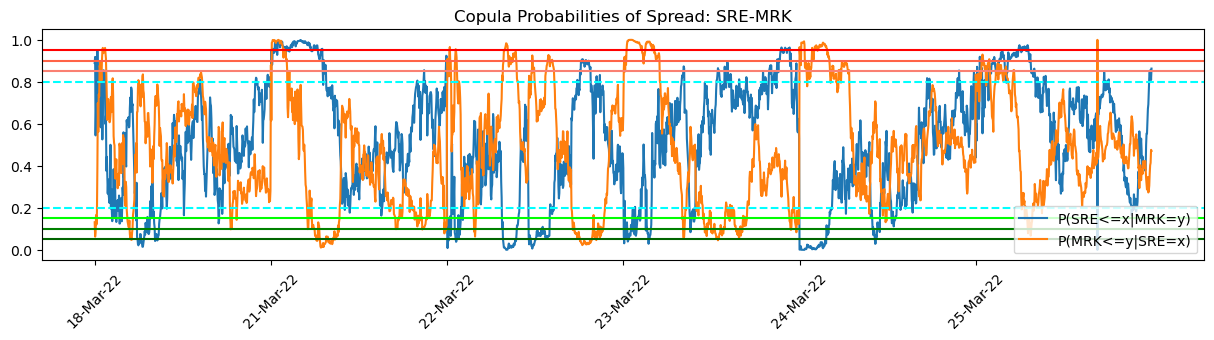

In [9]:
plot_signal(sig1, sig2, trading_price, pair)